## Introduction

This is my notebook that I used to explore the NYC Taxi Fare dataset. We predict the fare amount based on the provided features.

### Import necessary libraries


In [1]:
import pandas as pd
import numpy as np
from scipy.stats import norm
from scipy.stats import skew
from scipy import stats

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

from datetime import datetime


Load the data from notebook 'Part 1-EDA'

In [2]:
df = pd.read_csv('data.csv', index_col='Unnamed: 0')

C:\Users\Nastaran\Anaconda3\lib\site-packages\numpy\lib\arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [3]:
df.head()

,medallion,hack_license,vendor_id,rate_code,pickup_datetime,dropoff_datetime,passenger_count,trip_time_in_secs,trip_distance,pickup_longitude,...,tip_amount,tolls_amount,duration,pickup_hour,pickup_day,dropoff_hour,dropoff_day,LaGu_airport,haversine,speed
0,91F6EB84975BBC867E32CB113C7C2CD5,AD8751110E6292079EB10EB9481FE1A6,CMT,1,2013-04-04 18:47:45,2013-04-04 19:00:25,1,759,2.5,-73.957855,...,2.50,0.0,760,18,3,19,3,False,2.739544,12.976786
2,C1B9DA774DC2BBC6DE27CE994E7F44A0,E1B595FD55E4C82C1E213EB17438107A,CMT,1,2013-04-04 17:59:50,2013-04-04 18:21:48,1,1318,3.6,-73.982880,...,3.60,0.0,1318,17,3,18,3,False,4.928182,13.460892
3,9BA84250355AB3FC031C9252D395BF8A,16BB0D96A0DCC853AEC7F55C8D6C71E0,CMT,1,2013-04-04 18:12:01,2013-04-04 18:25:24,1,799,1.9,-73.978119,...,3.45,0.0,803,18,3,18,3,False,2.391527,10.721665
4,205A696DF62AD03C88DA8C5EC5248639,579C41EA5EC846F8B641A42F9EE3E855,CMT,1,2013-04-04 20:12:57,2013-04-04 20:29:55,1,1017,3.6,-74.006371,...,3.20,0.0,1018,20,3,20,3,False,4.178135,14.775329
5,EE75E5927D00739AC342810C336A825E,1B4E92431F9DA4D49874EC76E769E874,CMT,1,2013-04-05 02:48:11,2013-04-05 02:51:21,2,189,0.7,-73.985191,...,1.10,0.0,190,2,4,2,4,False,0.902749,17.104720


In [4]:
print('Total data size is {}'.format(df.shape))


Total data size is (14799601, 27)


In [5]:
df.isnull().any().sum()

0

In [6]:
df.dtypes

medallion             object
hack_license          object
vendor_id             object
rate_code              int64
pickup_datetime       object
dropoff_datetime      object
passenger_count        int64
trip_time_in_secs      int64
trip_distance        float64
pickup_longitude     float64
pickup_latitude      float64
dropoff_longitude    float64
dropoff_latitude     float64
payment_type          object
fare_amount          float64
surcharge            float64
mta_tax              float64
tip_amount           float64
tolls_amount         float64
duration               int64
pickup_hour            int64
pickup_day             int64
dropoff_hour           int64
dropoff_day            int64
LaGu_airport            bool
haversine            float64
speed                float64
dtype: object

In [7]:
df['rate_code'] = df['rate_code'].astype(str)


Lets have a look to the target variable, fare amount

C:\Users\Nastaran\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)



 mu = 12.20 and sigma = 9.49



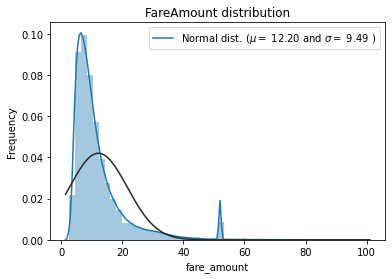

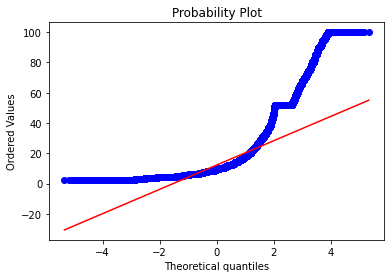

Skewness: 2.695717
Kurtosis: 9.285981


In [8]:
# Plot Histogram
sns.distplot(df['fare_amount'] , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(df['fare_amount'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('FareAmount distribution')

fig = plt.figure()
res = stats.probplot(df['fare_amount'], plot=plt)
plt.show()

print("Skewness: %f" % df['fare_amount'].skew())
print("Kurtosis: %f" % df['fare_amount'].kurt())

Does it look like a normal distribution? Not quite! Looking at the kurtosis score, we can see that there is a very nice peak in distribution plot. However, looking at the skewness score, we can see that the fare prices deviate from the normal distribution.

Based on discussion in notebook Part 2, we consider the maximum tip to be 20 USD.

In [9]:
df = df[df['tip_amount']<21]

### Including date-time features


In [10]:
df['pickup_datetime']  = pd.to_datetime(df['pickup_datetime'])
df['dropoff_datetime']  = pd.to_datetime(df['dropoff_datetime'])

In [11]:
print('Total data size is {}'.format(df.shape))


Total data size is (14795824, 27)


### Data Preparation

In [12]:
df.head()

,medallion,hack_license,vendor_id,rate_code,pickup_datetime,dropoff_datetime,passenger_count,trip_time_in_secs,trip_distance,pickup_longitude,...,tip_amount,tolls_amount,duration,pickup_hour,pickup_day,dropoff_hour,dropoff_day,LaGu_airport,haversine,speed
0,91F6EB84975BBC867E32CB113C7C2CD5,AD8751110E6292079EB10EB9481FE1A6,CMT,1,2013-04-04 18:47:45,2013-04-04 19:00:25,1,759,2.5,-73.957855,...,2.50,0.0,760,18,3,19,3,False,2.739544,12.976786
2,C1B9DA774DC2BBC6DE27CE994E7F44A0,E1B595FD55E4C82C1E213EB17438107A,CMT,1,2013-04-04 17:59:50,2013-04-04 18:21:48,1,1318,3.6,-73.982880,...,3.60,0.0,1318,17,3,18,3,False,4.928182,13.460892
3,9BA84250355AB3FC031C9252D395BF8A,16BB0D96A0DCC853AEC7F55C8D6C71E0,CMT,1,2013-04-04 18:12:01,2013-04-04 18:25:24,1,799,1.9,-73.978119,...,3.45,0.0,803,18,3,18,3,False,2.391527,10.721665
4,205A696DF62AD03C88DA8C5EC5248639,579C41EA5EC846F8B641A42F9EE3E855,CMT,1,2013-04-04 20:12:57,2013-04-04 20:29:55,1,1017,3.6,-74.006371,...,3.20,0.0,1018,20,3,20,3,False,4.178135,14.775329
5,EE75E5927D00739AC342810C336A825E,1B4E92431F9DA4D49874EC76E769E874,CMT,1,2013-04-05 02:48:11,2013-04-05 02:51:21,2,189,0.7,-73.985191,...,1.10,0.0,190,2,4,2,4,False,0.902749,17.104720


We get random samples of 300000 from df for our modelling purpose. Once we create the model and optimize it then we feed all the data to the model.

In [13]:
ds = df.sample(300000)

In [14]:
correlation = ds.corr()


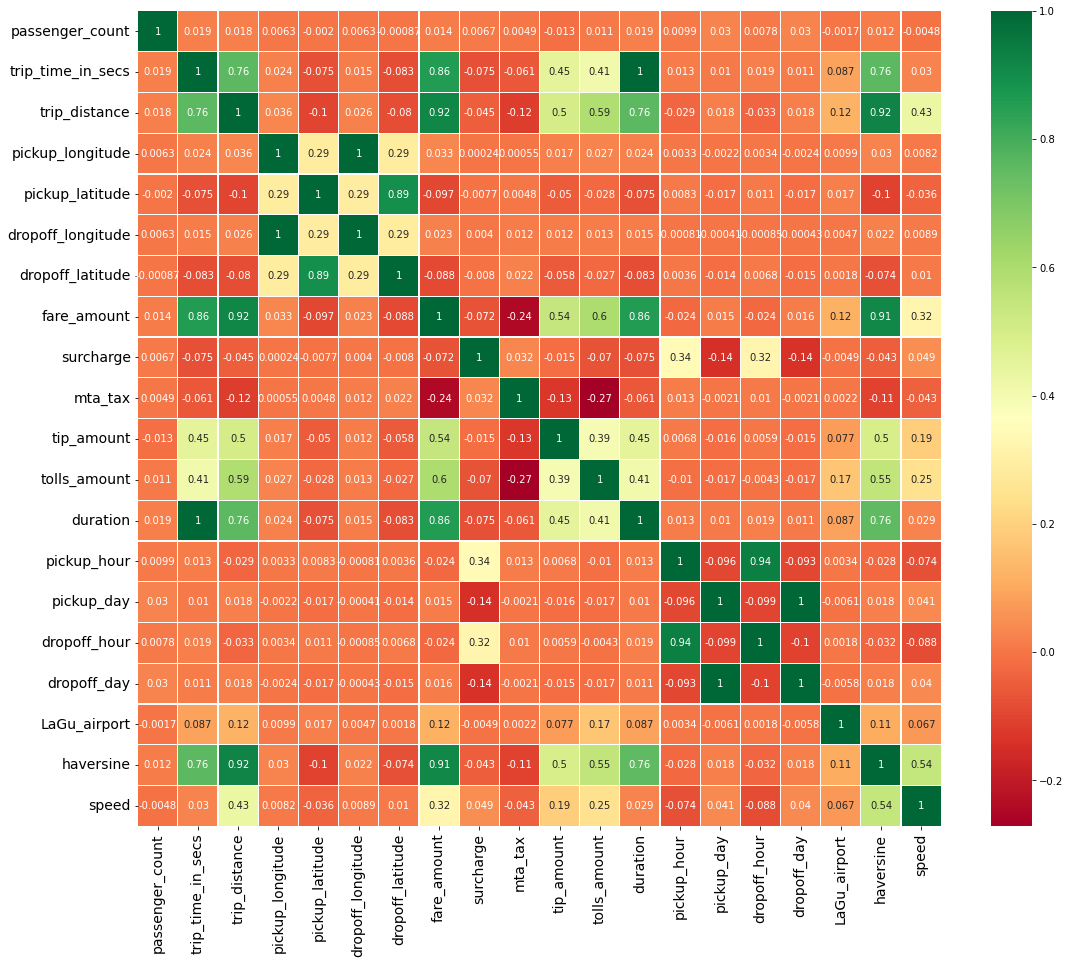

In [15]:
plt.figure(figsize=(10,8))
sns.heatmap(correlation,annot=True,cmap='RdYlGn',linewidths=0.2,annot_kws={'size':10})
fig=plt.gcf()
fig.set_size_inches(18,15)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

We drop those features which are highly correlated with the target. So, we drop the mta_tax, surcharge, tolls_amount since they have information of our target fare_amount.

In [16]:
ds = ds.drop(['pickup_datetime','dropoff_datetime', 'dropoff_longitude',
              'dropoff_latitude','dropoff_hour',
              'dropoff_day', 'trip_time_in_secs',
             'trip_distance', 'mta_tax', 'tolls_amount', 
              'surcharge','rate_code', 'passenger_count','vendor_id','payment_type'], axis =1 )

In [17]:
correlation = ds.corr()


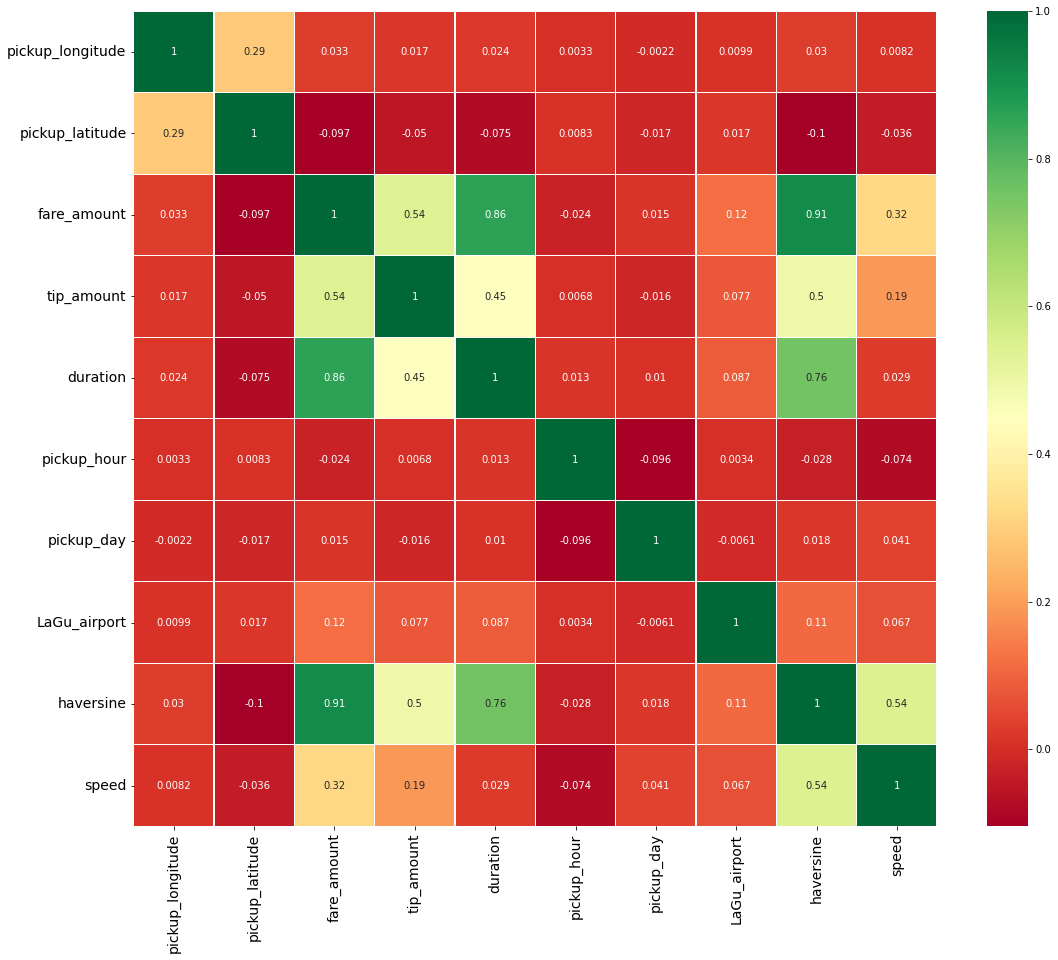

In [18]:
plt.figure(figsize=(10,8))
sns.heatmap(correlation,annot=True,cmap='RdYlGn',linewidths=0.2,annot_kws={'size':10})
fig=plt.gcf()
fig.set_size_inches(18,15)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

Define target and the features

In [19]:
y = ds['fare_amount']
x = ds.drop(['fare_amount','tip_amount'], axis =1 )

In [20]:
x = x.set_index(['medallion', 'hack_license'])


In [21]:
x.head()

,,pickup_longitude,pickup_latitude,duration,pickup_hour,pickup_day,LaGu_airport,haversine,speed
medallion,hack_license,,,,,,,,
69792B76B065ECEC19936D9795DFE1FA,F846CFD48F9C1C91D9FE5C229355E989,-73.971436,40.782169,1044,14,2,False,8.414418,29.015235
75D99CC82FA605FC92828660BD50AD47,E32A7CD4BDE9EC17A2EADA7A0662D6B6,-73.992805,40.761875,960,14,5,False,1.784289,6.691083
65BC9D2CB01498ED366C3ADB9B5AE9AB,D6285A70685087EA48DAA39BCF2F320A,-73.998947,40.734882,720,17,3,False,0.345535,1.727673
CF72BBD4470B9F1A6C2FB4DD54D56A56,DA1CA5E37E96DB8DA9F038C43ABEE62C,-73.990601,40.751045,180,21,0,False,0.679169,13.583387
C30B82408DD8D5EF17A081494009A1A4,F2037A2C54652EFFB7CEAD7A0D91AA8B,-73.993919,40.720509,660,3,6,False,0.202973,1.107127


In [22]:
#Features name

features_name = list(x.columns)
features_name

['pickup_longitude',
 'pickup_latitude',
 'duration',
 'pickup_hour',
 'pickup_day',
 'LaGu_airport',
 'haversine',
 'speed']

In [23]:
# one-hot encoding of categorical variables

# x = pd.get_dummies(x)

In [24]:
x.columns

Index(['pickup_longitude', 'pickup_latitude', 'duration', 'pickup_hour',
       'pickup_day', 'LaGu_airport', 'haversine', 'speed'],
      dtype='object')

In [25]:
x_train,x_test, y_train,y_test = train_test_split(x,y, random_state = 20, test_size=0.2)

In [26]:
# Scale each feature to 0-1
scaler = MinMaxScaler(feature_range = (0, 1))

# Fit on the training data and transform both training and testing data
scaler.fit(x_train)
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)

print('Training data shape: ', x_train.shape)
print('Testing data shape: ', x_test.shape)

Training data shape:  (240000, 8)
Testing data shape:  (60000, 8)


### Building Models

#### Baseline 

To make sure that machine learning is applicable to the task, we should compare these predictions to a baseline model. For a regression task, this can be as simple as the average value of the target in the training data.

In [27]:
train_mean = y_train.mean()


In [28]:
# Create list of the same prediction for every observation
train_preds = [train_mean for _ in range(len(y_train))]
test_preds = [train_mean for _ in range(len(y_test))]

#### Score Model
Here can we use the validation set for assessing the model? We will use two metrics:

1. Root mean squared error
2. Mean absolute percentage error: the average percentage error of the predictions

In [29]:
#mean squared error
train_rmse = np.sqrt(mean_squared_error(y_train, train_preds))
test_rmse = np.sqrt(mean_squared_error(y_test, test_preds))

In [30]:
print('RMSE: %.3f' % (train_rmse))
print('RMSE: %.3f' % (test_rmse))

RMSE: 9.474
RMSE: 9.530


In [31]:
train_mae = mean_absolute_error(y_train, train_preds)
test_mae = mean_absolute_error(y_test, test_preds)

In [32]:
print('MAE: %.3f' % (train_mae))
print('MAE: %.3f' % (test_mae))

MAE: 6.267
MAE: 6.289


#### First Model: Linear Regression

We train the linear regression using three features. The benefit of the linear regression is that it's interpretable and we can inspect and investigate the coefficients.

In [33]:
x_train = pd.DataFrame(data=x_train, columns=x.columns)

In [34]:
lr = LinearRegression()

In [35]:
lr.fit(x_train[['duration']], y_train)

print('Intercept', round(lr.intercept_, 4))
print('abs_lat_diff coef: ', round(lr.coef_[0], 4)) 
#       '\tabs_lon_diff coef:', round(lr.coef_[1], 4))


Intercept 1.1701
abs_lat_diff coef:  134.4624


In [36]:
x_test= pd.DataFrame(data=x_test, columns=x.columns)

In [37]:
y_pred = lr.predict(x_test[['duration']])

In [38]:
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print('RMSE: %.3f' % (rmse))

RMSE: 4.865


In [39]:
mae = mean_absolute_error(y_test, y_pred)
print('MAE: %.3f' % (mae))

MAE: 2.487


Having a decrease in rmse shows that we are in the right path. 

We perform the regression one more time and this time we include all the features.

In [40]:
lr = LinearRegression()
lr.fit(x_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [41]:
y_pred = lr.predict(x_test)

In [42]:
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print('RMSE: %.3f' % (rmse))

RMSE: 2.898


In [43]:
mae = mean_absolute_error(y_test, y_pred)
print('MAE: %.3f' % (mae))

MAE: 1.141


C:\Users\Nastaran\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Distribution of Random Forest Predicted Fare Amount')

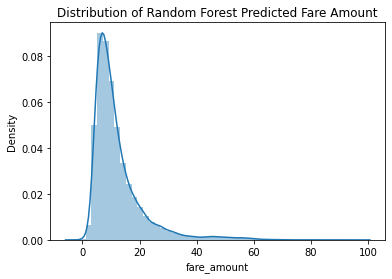

In [44]:
preds = lr.predict(x_test)
test_id = x_test.index

sub = pd.DataFrame({'key': test_id, 'fare_amount': preds})
sub.to_csv('sub_rf_simple.csv', index = False)

sns.distplot(sub['fare_amount'])
plt.title('Distribution of Random Forest Predicted Fare Amount')

#### Upgraded Model
When we want to improve performance, we generally have a few options:

* Get more data - either more observations or more variables
* Engineer more / better features
* Perform feature selection to remove irrelevant features
* Perform hyperparameter tuning of the selected model
*Try a more complex model

#### Second Model: Random Forest

In [45]:
# Create the random forest
random_forest = RandomForestRegressor()

# Train on data
random_forest.fit(x_train, y_train)

# predict 
y_pred = random_forest.predict(x_test)

In [46]:
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print('RMSE: %.3f' % (rmse))

RMSE: 2.360


In [47]:
mae = mean_absolute_error(y_test, y_pred)
print('MAE: %.3f' % (mae))

MAE: 0.865


In [48]:
x_test

,pickup_longitude,pickup_latitude,duration,pickup_hour,pickup_day,LaGu_airport,haversine,speed
0,0.056754,0.027573,0.151007,0.608696,0.666667,0.0,0.202895,0.239341
1,0.056464,0.028231,0.043912,0.478261,0.333333,0.0,0.023088,0.093495
2,0.056767,0.028844,0.032742,1.000000,0.500000,0.0,0.025105,0.136228
3,0.056821,0.029416,0.053876,0.521739,0.000000,0.0,0.042508,0.140363
4,0.056510,0.028756,0.118156,0.869565,0.833333,0.0,0.080557,0.121424
...,...,...,...,...,...,...,...,...
59995,0.056843,0.029423,0.019601,0.782609,0.333333,0.0,0.022044,0.199363
59996,0.056814,0.030440,0.045883,0.043478,0.500000,0.0,0.039319,0.152397
59997,0.057973,0.029991,0.361257,0.347826,0.000000,0.0,0.188520,0.092997
59998,0.056649,0.029070,0.104358,0.217391,0.833333,0.0,0.083854,0.143088


C:\Users\Nastaran\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Distribution of Random Forest Predicted Fare Amount')

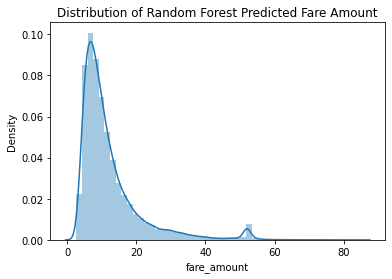

In [49]:
preds = random_forest.predict(x_test)
test_id = x_test.index

sub = pd.DataFrame({'key': test_id, 'fare_amount': preds})
sub.to_csv('sub_rf_simple.csv', index = False)

sns.distplot(sub['fare_amount'])
# sns.distplot(y_test)
plt.title('Distribution of Random Forest Predicted Fare Amount')

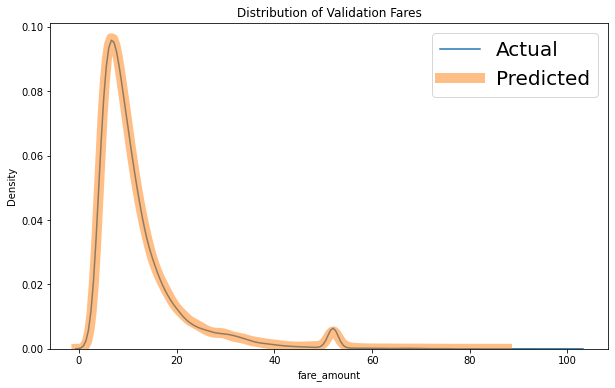

In [50]:
preds = random_forest.predict(x_test)

plt.figure(figsize = (10, 6))
sns.kdeplot(y_test, label = 'Actual')
sns.kdeplot(preds, label = 'Predicted',linewidth=10,alpha=.5)
plt.legend(prop = {'size': 20})
plt.title("Distribution of Validation Fares");

For comarision purpose, we  plot the predictions and original dataset.

In [51]:
feature_importance_values = random_forest.feature_importances_
feature_importances = pd.DataFrame({'feature': x.columns, 'importance': feature_importance_values})

In [52]:
feature_importances


,feature,importance
0,pickup_longitude,0.024099
1,pickup_latitude,0.012544
2,duration,0.220466
3,pickup_hour,0.008829
4,pickup_day,0.004009
5,LaGu_airport,0.000151
6,haversine,0.720132
7,speed,0.009770


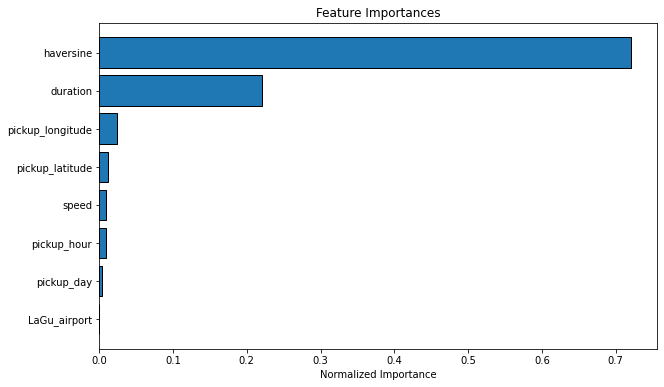

In [53]:
feature_importances = feature_importances.sort_values('importance', ascending = False).reset_index()
    
# Normalize the feature importances to add up to one
feature_importances['importance_normalized'] = feature_importances['importance'] / feature_importances['importance'].sum()

# Make a horizontal bar chart of feature importances
plt.figure(figsize = (10, 6))
ax = plt.subplot()
    
# Need to reverse the index to plot most important on top
ax.barh(list(reversed(list(feature_importances.index[:15]))), 
feature_importances['importance_normalized'].head(15), align = 'center', edgecolor = 'k')
    
# Set the yticks and labels
ax.set_yticks(list(reversed(list(feature_importances.index[:15]))))
ax.set_yticklabels(feature_importances['feature'].head(15))
    
# Plot labeling
plt.xlabel('Normalized Importance'); plt.title('Feature Importances')
plt.show()

#### Third Model: XGBoost

In [54]:
xgb = XGBRegressor()
# fit the model
xgb.fit(x_train, y_train)

C:\Users\Nastaran\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[00:10:04] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

In [55]:
# predict 
y_pred = xgb.predict(x_test)

In [56]:
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print('RMSE: %.3f' % (rmse))

RMSE: 2.472


In [57]:
mae = mean_absolute_error(y_test, y_pred)
print('MAE: %.3f' % (mae))

MAE: 0.939


In [58]:
#importance feature
feature_importance_values = xgb.feature_importances_

In [59]:
feature_importances = pd.DataFrame({'feature': list(x.columns), 'importance': feature_importance_values})


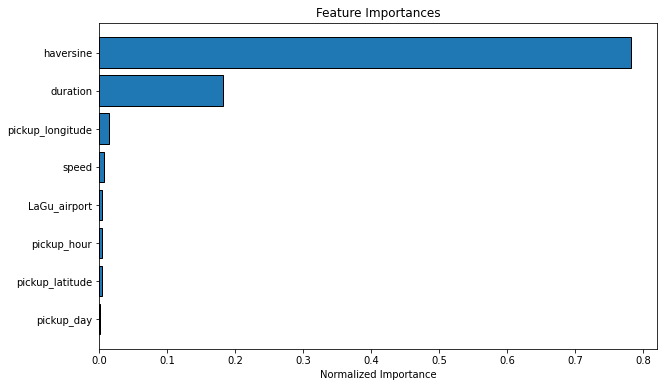

In [60]:
feature_importances = feature_importances.sort_values('importance', ascending = False).reset_index()
    
# Normalize the feature importances to add up to one
feature_importances['importance_normalized'] = feature_importances['importance'] / feature_importances['importance'].sum()

# Make a horizontal bar chart of feature importances
plt.figure(figsize = (10, 6))
ax = plt.subplot()
    
# Need to reverse the index to plot most important on top
ax.barh(list(reversed(list(feature_importances.index[:15]))), 
feature_importances['importance_normalized'].head(15), align = 'center', edgecolor = 'k')
    
# Set the yticks and labels
ax.set_yticks(list(reversed(list(feature_importances.index[:15]))))
ax.set_yticklabels(feature_importances['feature'].head(15))
    
# Plot labeling
plt.xlabel('Normalized Importance'); plt.title('Feature Importances')
plt.show()